#Tracking

This tutorial introduces the ``pvlib.tracking`` module. This module currently only contains one function, ``tracking.singleaxis``, but we hope to add dual axis tracking support in the future. 

The ``tracking.singleaxis`` function is a port of the PVLIB MATLAB file ``pvl_singleaxis.m``. The algorithm is based on [Lorenzo et al, *Tracking and back-tracking*, Prog. in Photovoltaics: Research and Applications, **19**, 747-753 (2011)](http://dx.doi.org/10.1002/pip.1085). Most of the Python and MATLAB algorithms are identical except for name changes to conform to the PEP8 Python style guide. There are few spots, noteably in the calculation of [``surface_azimuth``](#Surface-tilt-and-azimuth), that our implementation differs from the MATLAB implementation.

Table of contents:
1. [Standard Python and pvlib setup](#Setup).
2. [Walk through each step of the single axis tracking algorithm](#Single-axis-tracker-algorithm).
3. [Use the ``tracking.singleaxis`` function to explore the impacts of tracker tilt, tracker azimuth, and backtracking](#tracking.singleaxis-examples).

This tutorial has been tested against the following package versions:
* pvlib 0.2.0
* Python 2.7.10
* IPython 3.2
* Pandas 0.16.2

It should work with other Python and Pandas versions. It requires pvlib > 0.2.0 and IPython > 3.0.

This tutorial was written by
* Will Holmgren ([@wholmgren](http://wholmgren.github.io)), University of Arizona. March, 2015, July 2015.
* Some of the text is based on the comments in ``pvl_singleaxis.m``, presumably written by the PVLIB_MATLAB team at Sandia National Laboratory.

## Setup

Standard scientific Python imports.

In [1]:
# plotting modules
%matplotlib inline
import matplotlib.pyplot as plt
try:
    import seaborn as sns
    sns.set(rc={"figure.figsize": (12, 6)})
except ImportError:
    print('We suggest you install seaborn using conda or pip and rerun this cell')
    
# built in python modules
import datetime

# python add-ons
import numpy as np
import pandas as pd

In [2]:
import pvlib
from pvlib.tools import cosd, sind
from pvlib.location import Location

Make some ``pvlib Location`` objects. These are the standard inputs to the solar position calculator.

In [3]:
tus = Location(32.2, -111, 'US/Arizona', 700, 'Tucson')
print(tus)
johannesburg = Location(-26.2044, 28.0456, 'Africa/Johannesburg', 1753, 'Johannesburg')
print(johannesburg)

Tucson: latitude=32.2, longitude=-111, tz=US/Arizona, altitude=700
Johannesburg: latitude=-26.2044, longitude=28.0456, tz=Africa/Johannesburg, altitude=1753


Calculate solar position at those locations. To start, we'll choose times near an equinox. Later, we'll test against times near a solstice.

In [4]:
times = pd.date_range(start=datetime.datetime(2014,3,23), end=datetime.datetime(2014,3,24), freq='5Min')

pyephem_tus = pvlib.solarposition.pyephem(times, tus)
pyephem_joh = pvlib.solarposition.pyephem(times, johannesburg)
pyephemout = pyephem_tus # default for notebook

## Single axis tracker algorithm

The steps of the tracking algorithm are:
1. [Define input parameters](#Inputs).
2. [Transform solar position to South facing coordinate system](#Transform-to-south-facing-coordinate-system).
2. [Transform solar position to panel coordinate system](#Transform-to-panel-coordinate-system).
2. [Determine the ideal tracking angle when ignoring backtracking](#Tracking-angle).
2. [Correct the tracking angle to account for backtracking](#Backtracking).
2. [Calculate the panel normal vector based on tracking angle](#Calculate-panel-normal).
2. [Calculate the solar angle of incidence](#AOI).
2. [Calculate the panel tilt and azimuth](#Surface-tilt-and-azimuth).

### Inputs

First, define the input parameters. From the ``tracking.singleaxis`` docstring...

    apparent_zenith : Series
        Solar apparent zenith angles in decimal degrees. 

    azimuth : Series
        Solar azimuth angles in decimal degrees.

    latitude : float
        A value denoting which hempisphere the tracker is
        in. The exact latitude is NOT required, any positive number denotes
        the northern hemisphere, any negative number denotes the southern
        hemisphere, a value of 0 is assumed to be northern hemisphere.

    axis_tilt : float
        The tilt of the axis of rotation
        (i.e, the y-axis defined by axis_azimuth) with respect to horizontal, 
        in decimal degrees.

    axis_azimuth : float
        A value denoting the compass direction along which
        the axis of rotation lies, in decimal degrees. 

    max_angle : float
        A value denoting the maximum rotation angle, in
        decimal degrees, of the one-axis tracker from its horizontal position
        (horizontal if axis_tilt = 0). 
        A max_angle of 90 degrees allows the tracker to rotate to a vertical
        position to point the panel towards a horizon.  
        max_angle of 180 degrees allows for full rotation.

    backtrack : bool
        Controls whether the tracker has the
        capability to "backtrack" to avoid row-to-row shading. 
        False denotes no backtrack capability. 
        True denotes backtrack capability. 

    gcr : float
        A value denoting the ground coverage ratio of a tracker
        system which utilizes backtracking; i.e. the ratio between the PV
        array surface area to total ground area. A tracker system with modules 2
        meters wide, centered on the tracking axis, with 6 meters between the
        tracking axes has a gcr of 2/6=0.333. If gcr is not provided, a gcr
        of 2/7 is default. gcr must be <=1.

In [5]:
azimuth = pyephemout['azimuth']
apparent_azimuth = pyephemout['azimuth'] # not much difference, so cheat
apparent_zenith = pyephemout['apparent_zenith']
axis_tilt = 0
axis_azimuth = 170
latitude = 32
max_angle = 65 
backtrack = True
gcr = 2.0/7.0

times = azimuth.index

### Transform to south facing coordinate system

The reference that this algorithm is based on used an Earth coordinate system where y points south. So, we first transform our solar position vector to this new coordiante system.

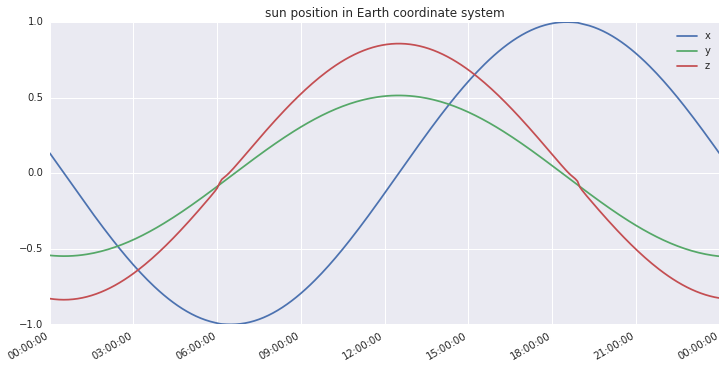

In [6]:
az = apparent_azimuth - 180
apparent_elevation = 90 - apparent_zenith
x = cosd(apparent_elevation) * sind(az)
y = cosd(apparent_elevation) * cosd(az)
z = sind(apparent_elevation)

earth_coords = pd.DataFrame({'x':x,'y':y,'z':z})

earth_coords.plot()
plt.title('sun position in Earth coordinate system')

### Transform to panel coordinate system

Transform solar vector to panel coordinate system. For North-South oriented trackers parallel to the ground, the only difference is the sign of the x component. The x components are the same if ``axis_azimuth=180`` and opposite if ``axis_azimuth=0``.

cos(axis_azimuth_south)=0.984807753012, sin(axis_azimuth_south)=-0.173648177667
cos(axis_tilt)=1.0, sin(axis_tilt)=0.0


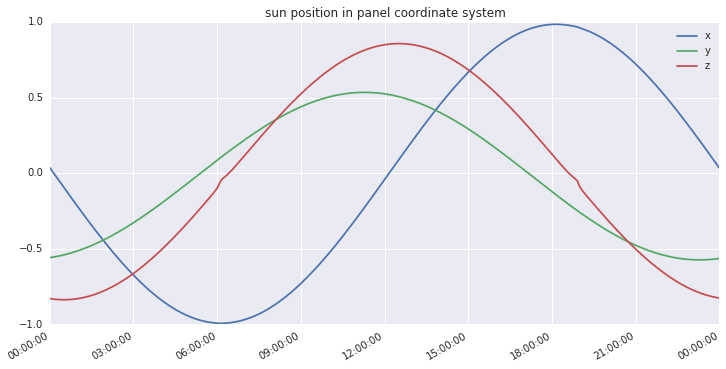

In [7]:
axis_azimuth_south = axis_azimuth - 180

print('cos(axis_azimuth_south)={}, sin(axis_azimuth_south)={}'
      .format(cosd(axis_azimuth_south), sind(axis_azimuth_south)))
print('cos(axis_tilt)={}, sin(axis_tilt)={}'
      .format(cosd(axis_tilt), sind(axis_tilt)))

xp = x*cosd(axis_azimuth_south) - y*sind(axis_azimuth_south);
yp = (x*cosd(axis_tilt)*sind(axis_azimuth_south) +
      y*cosd(axis_tilt)*cosd(axis_azimuth_south) -
      z*sind(axis_tilt))
zp = (x*sind(axis_tilt)*sind(axis_azimuth_south) +
      y*sind(axis_tilt)*cosd(axis_azimuth_south) +
      z*cosd(axis_tilt))

panel_coords = pd.DataFrame({'x':xp,'y':yp,'z':zp})

panel_coords.plot()
plt.title('sun position in panel coordinate system')

### Tracking angle

 The ideal tracking angle ``wid`` is the rotation to place the sun position 
 vector ``(xp, yp, zp)`` in the ``(y, z)`` plane; i.e. normal to the panel and 
 containing the axis of rotation.  ``wid = 0`` indicates that the panel is 
 horizontal.  Here, our convention is that a clockwise rotation is 
 positive, to view rotation angles in the same frame of reference as 
 azimuth.  For example, for a system with tracking axis oriented south, 
 a rotation toward the east is negative, and a rotation to the west is 
 positive.

We use ``arctan2``, but PVLIB MATLAB uses ``arctan``. Here prove that we get the same result.

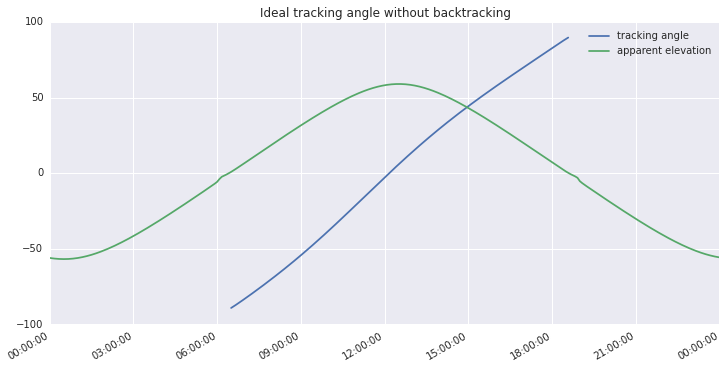

In [8]:
# Calculate angle from x-y plane to projection of sun vector onto x-z plane
# and then obtain wid by translating tmp to convention for rotation angles.
wid = pd.Series(90 - np.degrees(np.arctan2(zp, xp)), index=times)

# filter for sun above panel horizon
wid[zp <= 0] = np.nan

wid.plot(label='tracking angle')
pyephemout['apparent_elevation'].plot(label='apparent elevation')
plt.legend()
plt.title('Ideal tracking angle without backtracking')

``arctan`` version

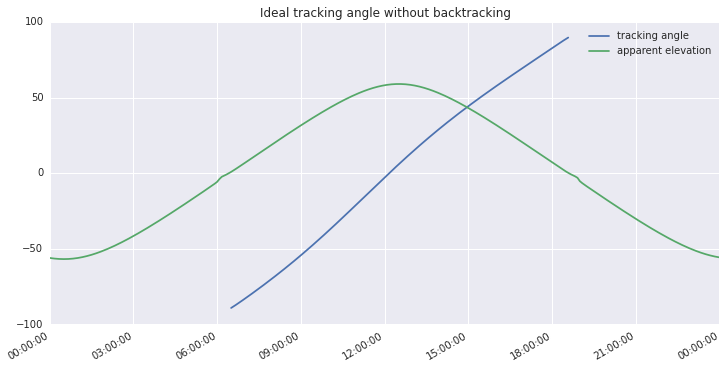

In [9]:
tmp = np.degrees(np.arctan(zp/xp))  # angle from x-y plane to projection of sun vector onto x-z plane

# Obtain wid by translating tmp to convention for rotation angles.
# Have to account for which quadrant of the x-z plane in which the sun 
# vector lies.  Complete solution here but probably not necessary to 
# consider QIII and QIV.
wid = pd.Series(index=times)
wid[(xp>=0) & (zp>=0)] =  90 - tmp[(xp>=0) & (zp>=0)];  # QI
wid[(xp<0)  & (zp>=0)] = -90 - tmp[(xp<0)  & (zp>=0)];  # QII
wid[(xp<0)  & (zp<0)]  = -90 - tmp[(xp<0)  & (zp<0)];   # QIII
wid[(xp>=0) & (zp<0)]  =  90 - tmp[(xp>=0) & (zp<0)];   # QIV

# filter for sun above panel horizon
wid[zp <= 0] = np.nan

wid.plot(label='tracking angle')
pyephemout['apparent_elevation'].plot(label='apparent elevation')
plt.legend()
plt.title('Ideal tracking angle without backtracking')

### Backtracking

Account for backtracking; modified from [1] to account for rotation angle convention being used here.

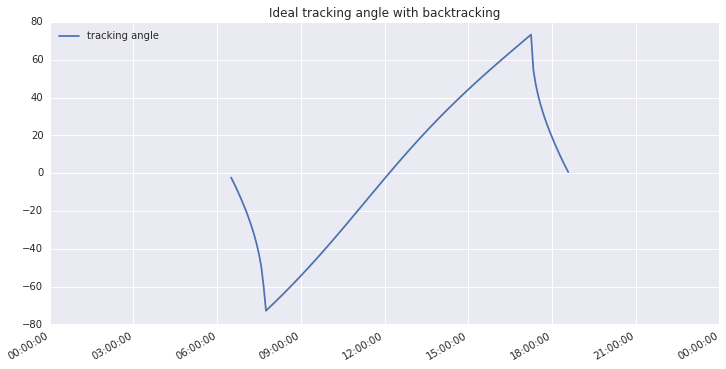

In [10]:
if backtrack:
    axes_distance = 1/gcr
    temp = np.minimum(axes_distance*cosd(wid), 1)

    # backtrack angle
    # (always positive b/c acosd returns values between 0 and 180)
    wc = np.degrees(np.arccos(temp))

    v = wid < 0
    widc = pd.Series(index=times)
    widc[~v] = wid[~v] - wc[~v]; # Eq 4 applied when wid in QI
    widc[v] = wid[v] + wc[v];    # Eq 4 applied when wid in QIV
else:
    widc = wid

widc.plot(label='tracking angle')
#pyephemout['apparent_elevation'].plot(label='apparent elevation')
plt.legend(loc=2)
plt.title('Ideal tracking angle with backtracking')

Compare tracking angle with and without backtracking.

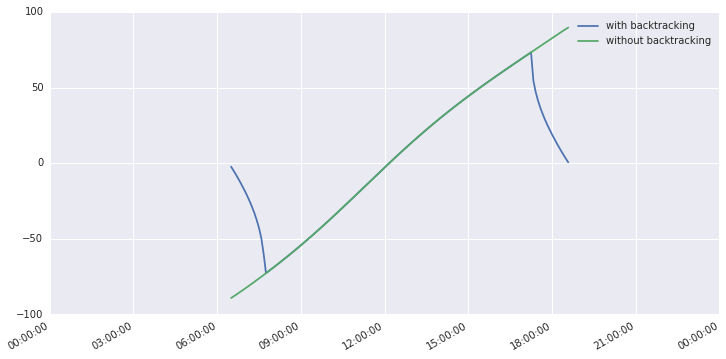

In [11]:
tracking_angles = pd.DataFrame({'with backtracking':widc,'without backtracking':wid})
tracking_angles.plot()
#pyephemout['apparent_elevation'].plot(label='apparent elevation')
plt.legend()

### Max angle

Apply angle restriction.

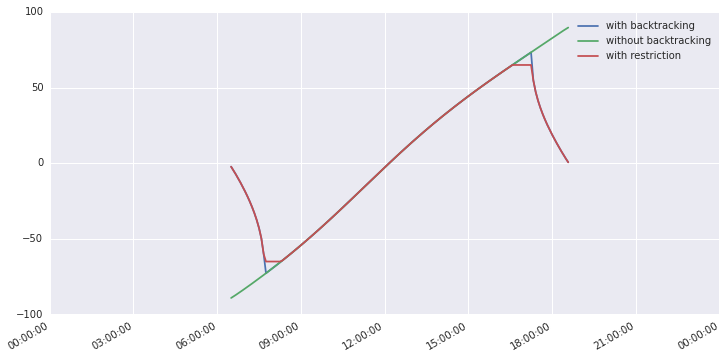

In [12]:
tracker_theta = widc.copy()
tracker_theta[tracker_theta > max_angle] = max_angle
tracker_theta[tracker_theta < -max_angle] = -max_angle

tracking_angles['with restriction'] = tracker_theta
tracking_angles.plot()

### Calculate panel normal

Calculate panel normal vector in panel x, y, z coordinates.
y-axis is axis of tracker rotation.  ``tracker_theta`` is a compass angle
(clockwise is positive) rather than a trigonometric angle.

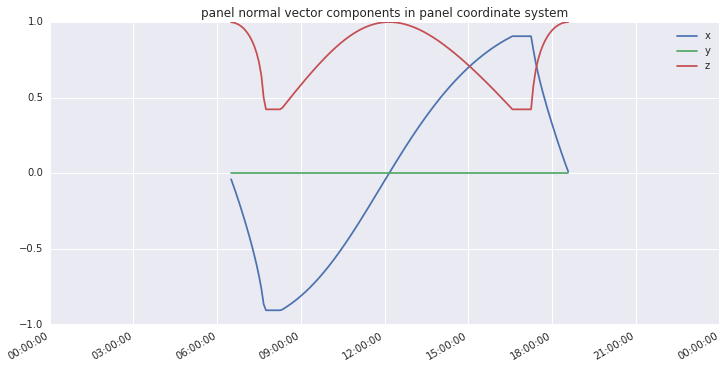

In [13]:
panel_norm = np.array([sind(tracker_theta), 
                       tracker_theta*0,
                       cosd(tracker_theta)])

panel_norm_df = pd.DataFrame(panel_norm.T, columns=('x','y','z'), index=times)
panel_norm_df.plot()
plt.title('panel normal vector components in panel coordinate system')
plt.legend()

sun position in vector format in panel-oriented x, y, z coordinates. We've already seen this above, but it's good to look at it again after calculating the tracker normal vector.

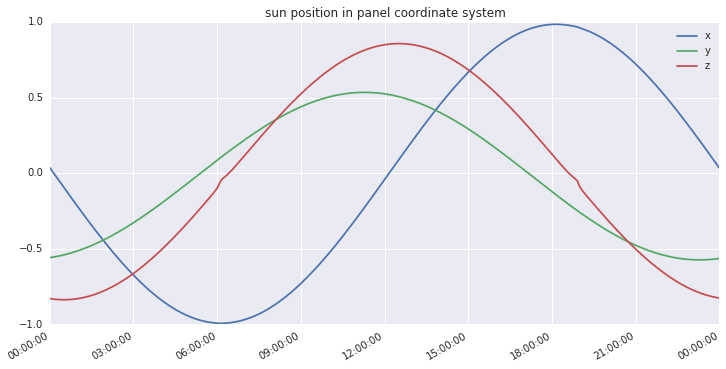

In [14]:
sun_vec = np.array([xp, yp, zp])

panel_coords = pd.DataFrame(sun_vec.T, columns=('x','y','z'), index=times)

panel_coords.plot()
plt.title('sun position in panel coordinate system')

### AOI

Calculate angle-of-incidence on panel

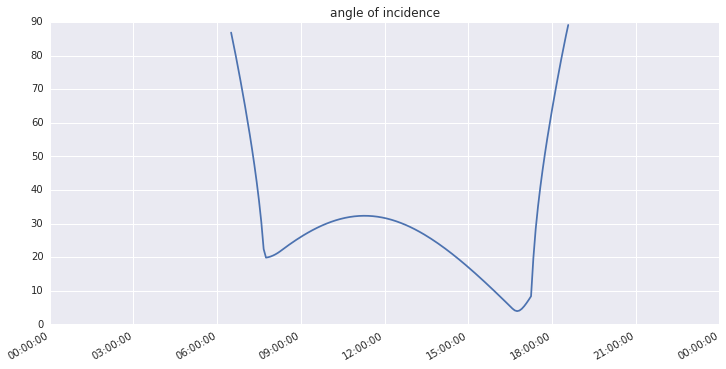

In [15]:
aoi = np.degrees(np.arccos(np.abs(np.sum(sun_vec*panel_norm, axis=0))))
aoi = pd.Series(aoi, index=times)

aoi.plot()
plt.title('angle of incidence')

The power produced by the tracker will be primarily determined by the cosine of the angle of incidence.

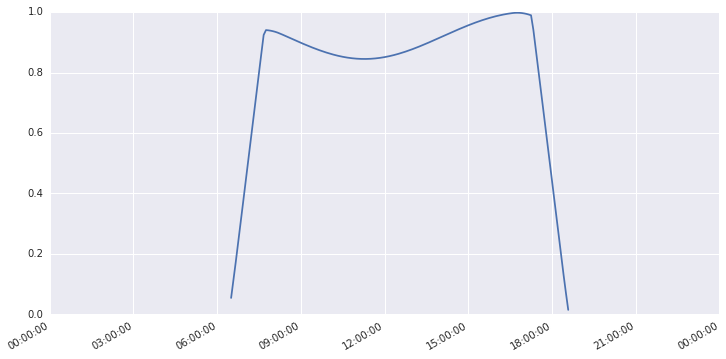

In [16]:
cosd(aoi).plot()

### Surface tilt and azimuth

Calculate panel tilt ``surface_tilt`` and azimuth ``surface_azimuth``
in a coordinate system where the panel tilt is the 
angle from horizontal, and the panel azimuth is
the compass angle (clockwise from north) to the projection 
of the panel's normal to the earth's surface. 
These outputs are provided for convenience and comparison 
with other PV software which use these angle conventions.

Project normal vector to earth surface. First rotate about x-axis by angle -axis_tilt so that y-axis is also parallel to earth surface, then project.

cos(axis_azimuth_south)=0.984807753012, sin(axis_azimuth_south)=-0.173648177667
cos(axis_tilt)=1.0, sin(axis_tilt)=0.0


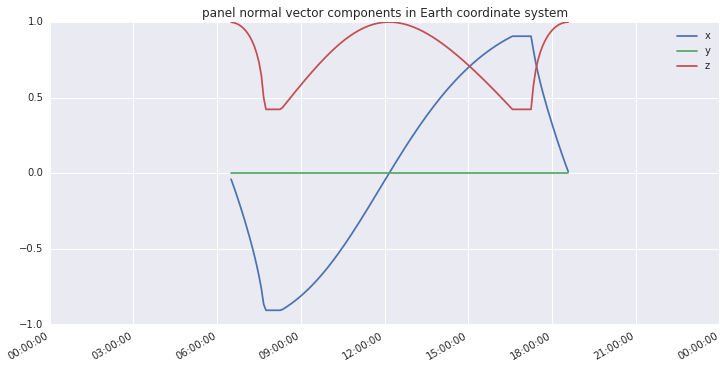

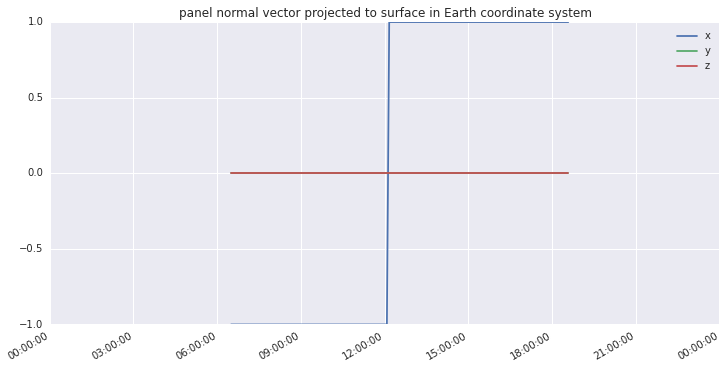

In [17]:
# Calculate standard rotation matrix
print('cos(axis_azimuth_south)={}, sin(axis_azimuth_south)={}'
      .format(cosd(axis_azimuth_south), sind(axis_azimuth_south)))
print('cos(axis_tilt)={}, sin(axis_tilt)={}'
      .format(cosd(axis_tilt), sind(axis_tilt)))

rot_x = np.array([[1, 0, 0], 
                  [0, cosd(-axis_tilt), -sind(-axis_tilt)], 
                  [0, sind(-axis_tilt), cosd(-axis_tilt)]])

# panel_norm_earth contains the normal vector expressed in earth-surface coordinates
# (z normal to surface, y aligned with tracker axis parallel to earth)
panel_norm_earth = np.dot(rot_x, panel_norm).T

# projection to plane tangent to earth surface,
# in earth surface coordinates
projected_normal = np.array([panel_norm_earth[:,0], panel_norm_earth[:,1], panel_norm_earth[:,2]*0]).T

# calculate magnitudes
panel_norm_earth_mag = np.sqrt(np.nansum(panel_norm_earth**2, axis=1))
projected_normal_mag = np.sqrt(np.nansum(projected_normal**2, axis=1))
#print('panel_norm_earth_mag={}, projected_normal_mag={}'.format(panel_norm_earth_mag, projected_normal_mag))

projected_normal = (projected_normal.T / projected_normal_mag).T

panel_norm_earth_df = pd.DataFrame(panel_norm_earth, columns=('x','y','z'), index=times)
panel_norm_earth_df.plot()
plt.title('panel normal vector components in Earth coordinate system')

projected_normal_df = pd.DataFrame(projected_normal, columns=('x','y','z'), index=times)
projected_normal_df.plot()
plt.title('panel normal vector projected to surface in Earth coordinate system')

#### Surface azimuth

Calculate surface_azimuth. This takes a few steps. We need to take the arctan, rotate from the panel system to the south-facing Earth system and then rotate the Earth system to a north-facing Earth system. We use the ``arctan2`` function, but PVLIB MATLAB uses ``arctan``.

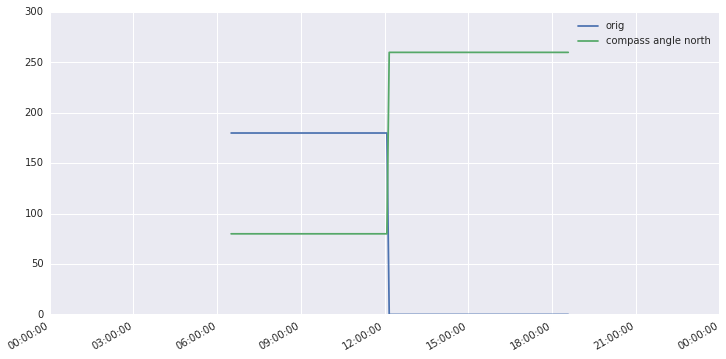

In [18]:
# calculation of surface_azimuth
# 1. Find the angle.
surface_azimuth = pd.Series(np.degrees(np.arctan2(projected_normal[:,1], projected_normal[:,0])), index=times)
surface_azimuth.plot(label='orig')

# 2. Rotate 0 reference from panel's x axis to it's y axis and
#    then back to North.
surface_azimuth += 90 + axis_azimuth

# 3. Map azimuth into [0,360) domain.
surface_azimuth[surface_azimuth<0] += 360
surface_azimuth[surface_azimuth>=360] -= 360
surface_azimuth.plot(label='compass angle north')

plt.legend()

``arctan`` version

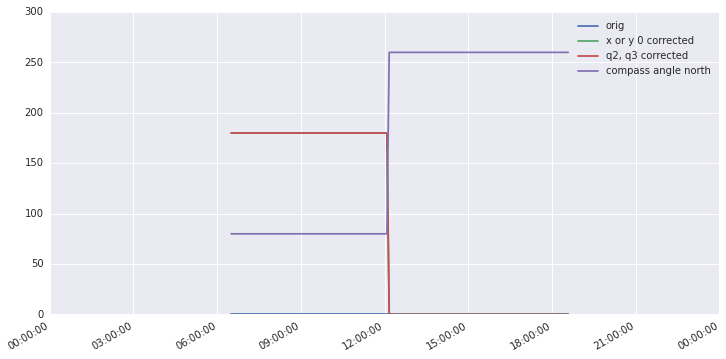

In [19]:
# calculation of surface_azimuth
# 1. Find the angle.
surface_azimuth = pd.Series(np.degrees(np.arctan(projected_normal[:,1]/projected_normal[:,0])), index=times)
surface_azimuth.plot(label='orig')

# 2. Clean up atan when x-coord or y-coord is zero
surface_azimuth[(projected_normal[:,0]==0) & (projected_normal[:,1]>0)] =  90
surface_azimuth[(projected_normal[:,0]==0) & (projected_normal[:,1]<0)] =  -90
surface_azimuth[(projected_normal[:,1]==0) & (projected_normal[:,0]>0)] =  0
surface_azimuth[(projected_normal[:,1]==0) & (projected_normal[:,0]<0)] = 180
surface_azimuth.plot(label='x or y 0 corrected')

# 3. Correct atan for QII and QIII
surface_azimuth[(projected_normal[:,0]<0) & (projected_normal[:,1]>0)] += 180 # QII
surface_azimuth[(projected_normal[:,0]<0) & (projected_normal[:,1]<0)] += 180 # QIII
surface_azimuth.plot(label='q2, q3 corrected')

# 4. Skip to below

# From PVLIB MATLAB...
# at this point surface_azimuth contains angles between -90 and +270,
# where 0 is along the positive x-axis,
# the y-axis is in the direction of the tracker azimuth,
# and positive angles are rotations from the positive x axis towards
# the positive y-axis.
# Adjust to compass angles
# (clockwise rotation from 0 along the positive y-axis)
#    surface_azimuth[surface_azimuth<=90] = 90 - surface_azimuth[surface_azimuth<=90]
#    surface_azimuth[surface_azimuth>90] = 450 - surface_azimuth[surface_azimuth>90]

# finally rotate to align y-axis with true north
# PVLIB_MATLAB has this latitude correction,
# but I don't think it's latitude dependent if you always
# specify axis_azimuth with respect to North.
#     if latitude > 0 or True:
#         surface_azimuth = surface_azimuth - axis_azimuth
#     else:
#         surface_azimuth = surface_azimuth - axis_azimuth - 180
#     surface_azimuth[surface_azimuth<0] = 360 + surface_azimuth[surface_azimuth<0]

# the commented code above is mostly part of PVLIB_MATLAB.
# My (wholmgren) take is that it can be done more simply.
# Say that we're pointing along the postive x axis (likely west).
# We just need to rotate 90 degrees to get from the x axis
# to the y axis (likely south),
# and then add the axis_azimuth to get back to North.
# Anything left over is the azimuth that we want,
# and we can map it into the [0,360) domain.


# 4. Rotate 0 reference from panel's x axis to it's y axis and
#    then back to North.
surface_azimuth += 90 + axis_azimuth

# 5. Map azimuth into [0,360) domain.
surface_azimuth[surface_azimuth<0] += 360
surface_azimuth[surface_azimuth>=360] -= 360
surface_azimuth.plot(label='compass angle north')

plt.legend()

The final ``surface_azimuth`` is given by the curve labeled "compass angle north". This is in degrees East of North.

#### Surface tilt

Calculate ``surface_tilt``. We use the pandas ``sum`` function because it evaluates ``pd.Series([np.nan]).sum()=nan`` whereas numpy evaluates ``np.nansum(np.array([np.nan]))=0``.

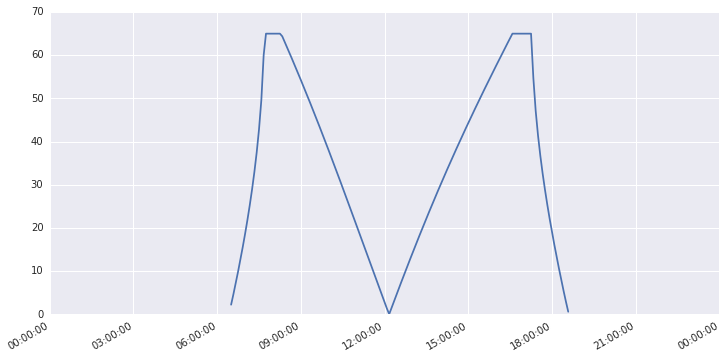

In [20]:
surface_tilt = (90 - np.degrees(np.arccos(
            pd.DataFrame(panel_norm_earth * projected_normal, index=times).sum(axis=1))))

surface_tilt.plot()

According to the MATLAB code, surface_tilt is "The angle between the panel surface and the earth surface, accounting for panel rotation."

## ``tracking.singleaxis`` examples 

With backtracking

In [21]:
tracker_data = pvlib.tracking.singleaxis(pyephemout['apparent_zenith'], pyephemout['apparent_azimuth'],
                                         axis_tilt=0, axis_azimuth=180, max_angle=90,
                                         backtrack=True, gcr=2.0/7.0)

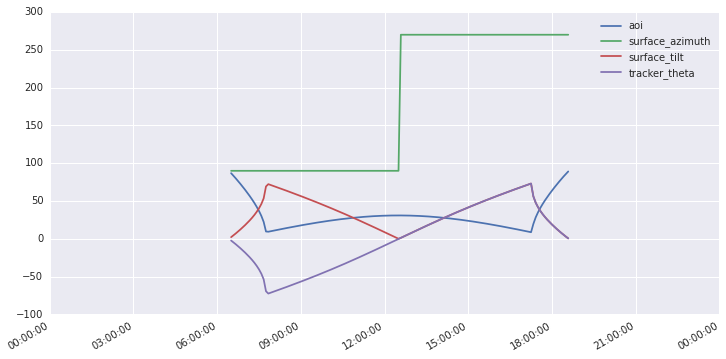

In [22]:
tracker_data.plot()

Without backtracking

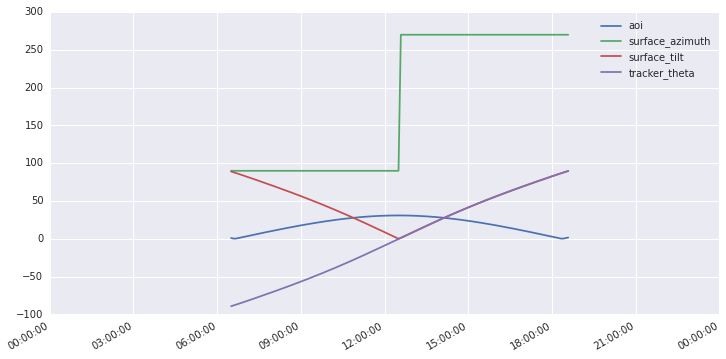

In [23]:
tracker_data = pvlib.tracking.singleaxis(pyephemout['apparent_zenith'], pyephemout['apparent_azimuth'],
                                         axis_tilt=0, axis_azimuth=180, max_angle=90,
                                         backtrack=False, gcr=2.0/7.0)
tracker_data.plot()

Explore ground cover ratio

In [24]:
aois = pd.DataFrame(index=pyephemout.index)

for gcr in np.linspace(0, 1, 6):
    tracker_data = pvlib.tracking.singleaxis(pyephemout['apparent_zenith'], pyephemout['apparent_azimuth'],
                                         axis_tilt=0, axis_azimuth=180, max_angle=90,
                                         backtrack=True, gcr=gcr)
    aois[gcr] = tracker_data['aoi']

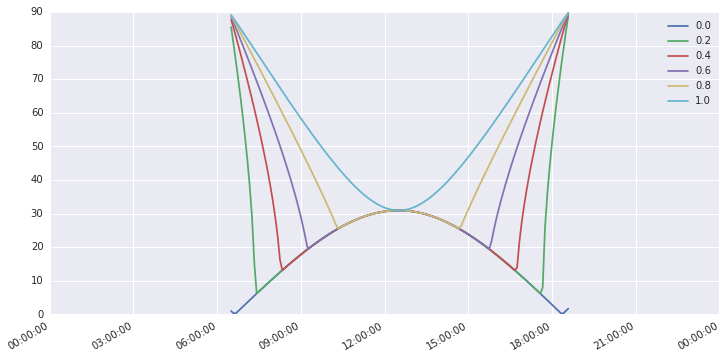

In [25]:
aois.plot()

Ensure that max_angle works.

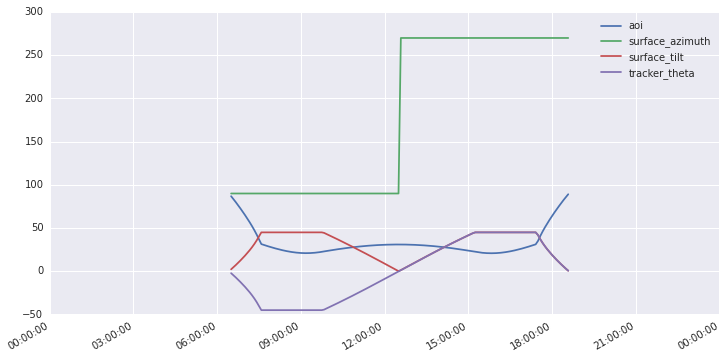

In [26]:
tracker_data = pvlib.tracking.singleaxis(pyephemout['apparent_zenith'], pyephemout['apparent_azimuth'],
                                         axis_tilt=0, axis_azimuth=180, max_angle=45,
                                         backtrack=True, gcr=2.0/7.0)
tracker_data.plot()

Play with axis_tilt.

(0, 360)

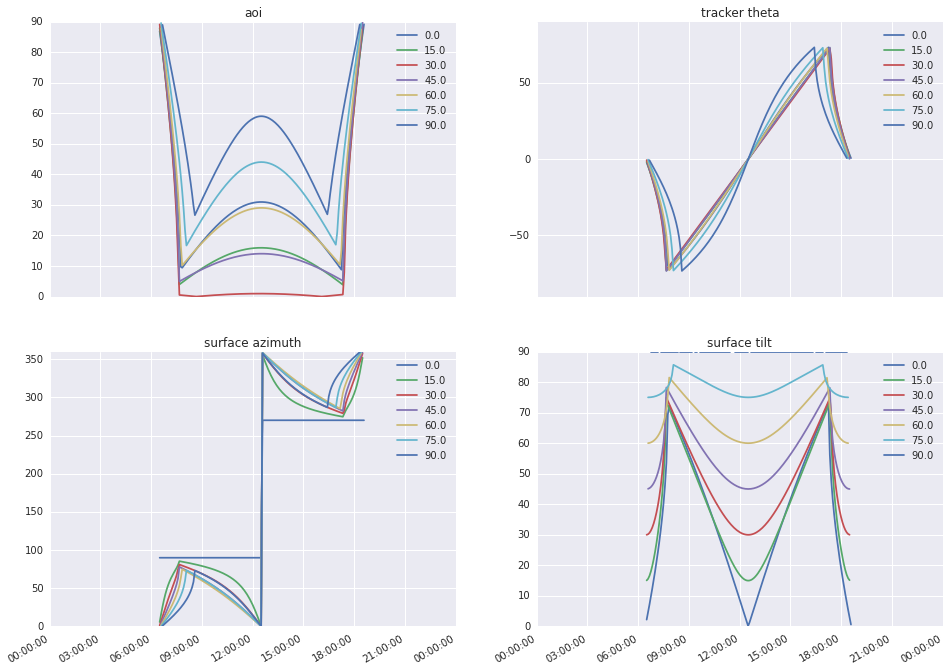

In [27]:
aois = pd.DataFrame(index=pyephemout.index)
tilts = pd.DataFrame(index=pyephemout.index)
azis = pd.DataFrame(index=pyephemout.index)
thetas = pd.DataFrame(index=pyephemout.index)

for tilt in np.linspace(0, 90, 7):
    tracker_data = pvlib.tracking.singleaxis(pyephemout['apparent_zenith'], pyephemout['apparent_azimuth'],
                                         axis_tilt=tilt, axis_azimuth=180, max_angle=90,
                                         backtrack=True, gcr=2/7.)
    aois[tilt] = tracker_data['aoi']
    tilts[tilt] = tracker_data['surface_tilt']
    azis[tilt] = tracker_data['surface_azimuth']
    thetas[tilt] = tracker_data['tracker_theta']
    
fig, axes = plt.subplots(2, 2, figsize=(16,12), sharex=True)
ax=axes[0,0]
aois.plot(ax=ax)
ax.set_ylim(0,90)
ax.set_title('aoi')

ax=axes[0,1]
thetas.plot(ax=ax)
ax.set_ylim(-90,90)
ax.set_title('tracker theta')

ax=axes[1,1]
tilts.plot(ax=ax)
ax.set_title('surface tilt')
ax.set_ylim(0,90)

ax=axes[1,0]
azis.plot(ax=ax)
ax.set_title('surface azimuth')
ax.set_ylim(0,360)

Makes sense if the panels are facing South at solar noon, as expected with ``axis_tilt>0`` and ``axis_azimuth=180``.

The limiting cases of 0 (flat) and 90 (vertical) seem to make sense if you switch the backtracking on and off. 

Next, try to point the panels North.

(0, 100)

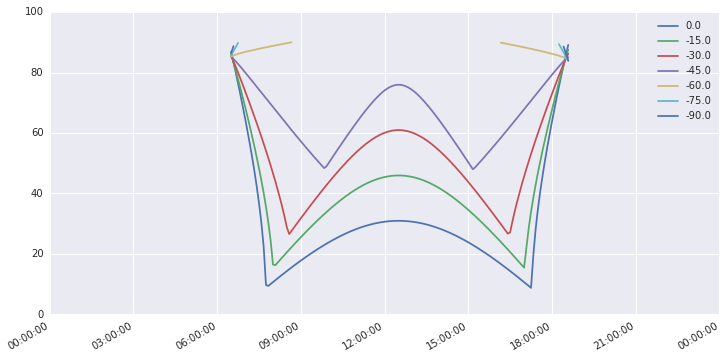

In [28]:
aois = pd.DataFrame(index=pyephemout.index)

for tilt in np.linspace(0, -90, 7):
    tracker_data = pvlib.tracking.singleaxis(pyephemout['apparent_zenith'], pyephemout['apparent_azimuth'],
                                         axis_tilt=tilt, axis_azimuth=180, max_angle=90,
                                         backtrack=True, gcr=2/7.)
    aois[tilt] = tracker_data['aoi']
    
aois.plot()
plt.ylim(0,100)

Makes sense if the panels are facing North at solar noon, as expected with ``axis_tilt<0`` and ``axis_azimuth=180``.

Play with axis_azimuth.

(0, 360)

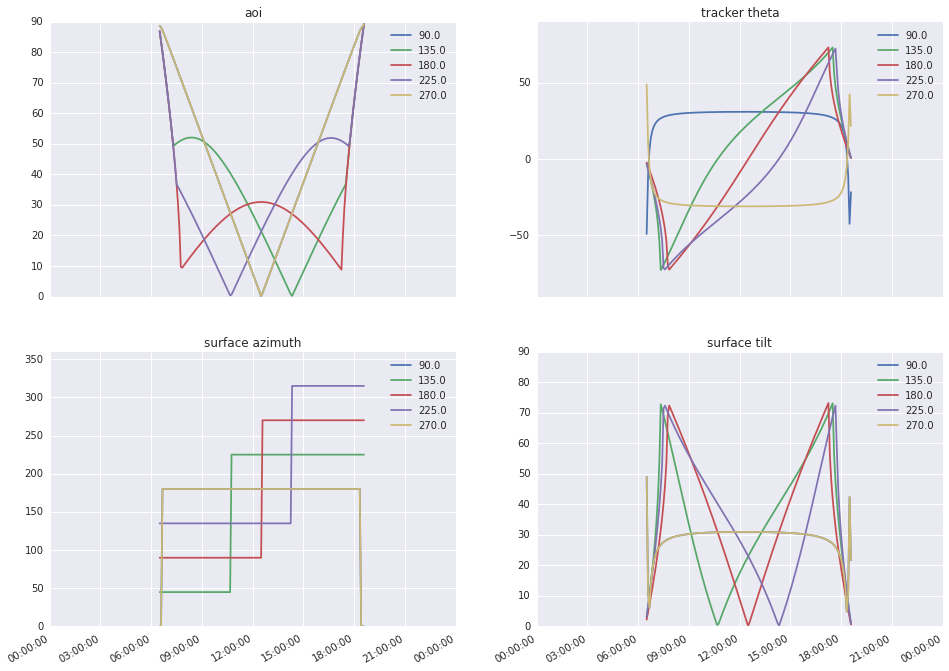

In [29]:
aois = pd.DataFrame(index=pyephemout.index)
tilts = pd.DataFrame(index=pyephemout.index)
azis = pd.DataFrame(index=pyephemout.index)
thetas = pd.DataFrame(index=pyephemout.index)

for azi in np.linspace(90, 270, 5):
    tracker_data = pvlib.tracking.singleaxis(pyephemout['apparent_zenith'], pyephemout['apparent_azimuth'],
                                         axis_tilt=0, axis_azimuth=azi, max_angle=90,
                                         backtrack=True, gcr=2/7.)
    aois[azi] = tracker_data['aoi']
    tilts[azi] = tracker_data['surface_tilt']
    azis[azi] = tracker_data['surface_azimuth']
    thetas[azi] = tracker_data['tracker_theta']
    
fig, axes = plt.subplots(2, 2, figsize=(16,12), sharex=True)
ax=axes[0,0]
aois.plot(ax=ax)
ax.set_ylim(0,90)
ax.set_title('aoi')

ax=axes[0,1]
thetas.plot(ax=ax)
ax.set_ylim(-90,90)
ax.set_title('tracker theta')

ax=axes[1,1]
tilts.plot(ax=ax)
ax.set_title('surface tilt')
ax.set_ylim(0,90)

ax=axes[1,0]
azis.plot(ax=ax)
ax.set_title('surface azimuth')
ax.set_ylim(0,360)

Since I screwed up the ``axis_azimuth`` calculation before, this is worth spending a minute on. This discussion assumes ``axis_tilt=0`` and no backtracking.

Say that your ``axis_azimuth=90 or 270``. Your ``surface_azimuth`` has no choice but to point to North (0), or South (180). Near the equinox, the solar azimuth is very nearly 90 at sunrise and sunset, so the ``surface_tilt`` is going to be poorly defined until the sun is a bit above the horizon. At midday, the ``surface_azimuth`` should definitely point South (180), ``surface_tilt`` will very nearly equal the latitude, and AOI should be nearly 0.

Next, let's study the ``axis_azimuth=135`` case. This corresponds to a tracker oriented from SSE-NNW. At sunrise, on the equinox, the tracker is going to point East of North by 45 degrees. Sometime before solar noon, the panels should lay flat, and then point West of South by 45 degrees, or East of North by 225.

Test the southern hemispere.

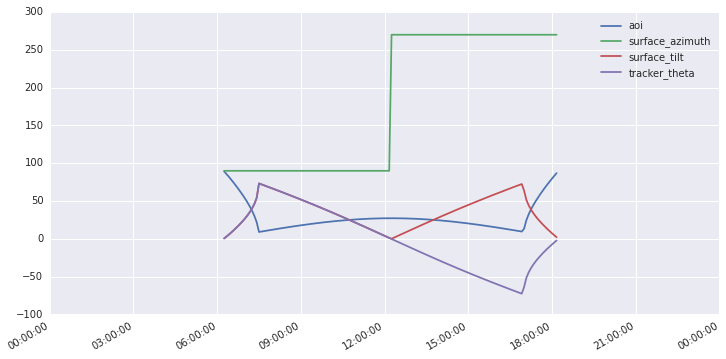

In [30]:
tracker_data = pvlib.tracking.singleaxis(pyephem_joh['apparent_zenith'], pyephem_joh['apparent_azimuth'],
                                         axis_tilt=0, axis_azimuth=0, max_angle=90,
                                         backtrack=True, gcr=2.0/7.0)
tracker_data.plot()

Test different seasons.

(-100, 100)

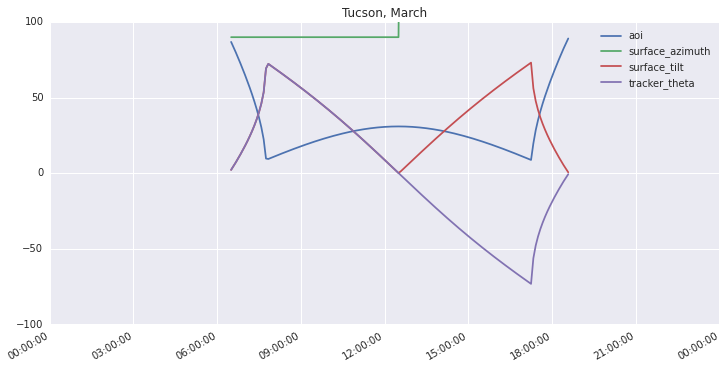

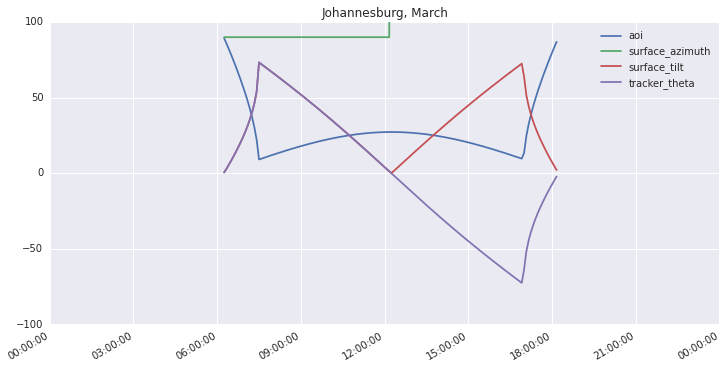

In [31]:
times = pd.date_range(start=datetime.datetime(2014,3,23), end=datetime.datetime(2014,3,24), freq='5Min')

pyephem_tus = pvlib.solarposition.pyephem(times, tus)
pyephem_joh = pvlib.solarposition.pyephem(times, johannesburg)

tracker_data = pvlib.tracking.singleaxis(pyephem_tus['apparent_zenith'], pyephem_tus['apparent_azimuth'],
                                         axis_tilt=0, axis_azimuth=0, max_angle=90,
                                         backtrack=True, gcr=2.0/7.0)
tracker_data.plot()
plt.title('Tucson, March')
plt.ylim(-100,100)

tracker_data = pvlib.tracking.singleaxis(pyephem_joh['apparent_zenith'], pyephem_joh['apparent_azimuth'],
                                         axis_tilt=0, axis_azimuth=0, max_angle=90,
                                         backtrack=True, gcr=2.0/7.0)
tracker_data.plot()
plt.title('Johannesburg, March')
plt.ylim(-100,100)

(-100, 100)

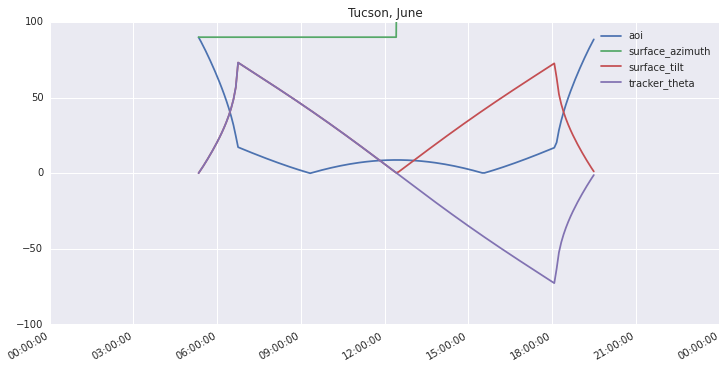

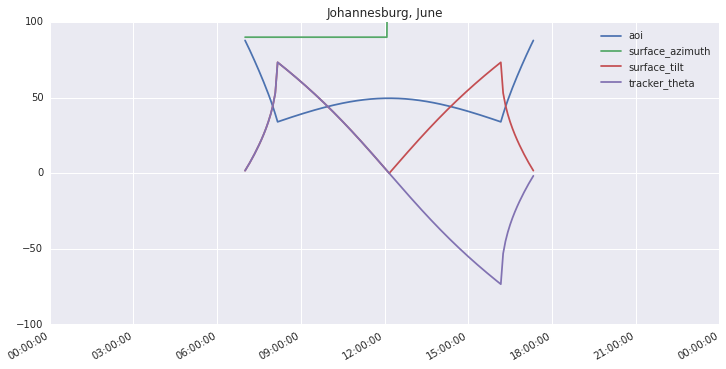

In [32]:
times = pd.date_range(start=datetime.datetime(2014,6,23), end=datetime.datetime(2014,6,24), freq='5Min')

pyephem_tus = pvlib.solarposition.pyephem(times, tus)
pyephem_joh = pvlib.solarposition.pyephem(times, johannesburg)

tracker_data = pvlib.tracking.singleaxis(pyephem_tus['apparent_zenith'], pyephem_tus['apparent_azimuth'],
                                         axis_tilt=0, axis_azimuth=0, max_angle=90,
                                         backtrack=True, gcr=2.0/7.0)
tracker_data.plot()
plt.title('Tucson, June')
plt.ylim(-100,100)

tracker_data = pvlib.tracking.singleaxis(pyephem_joh['apparent_zenith'], pyephem_joh['apparent_azimuth'],
                                         axis_tilt=0, axis_azimuth=0, max_angle=90,
                                         backtrack=True, gcr=2.0/7.0)
tracker_data.plot()
plt.title('Johannesburg, June')
plt.ylim(-100,100)

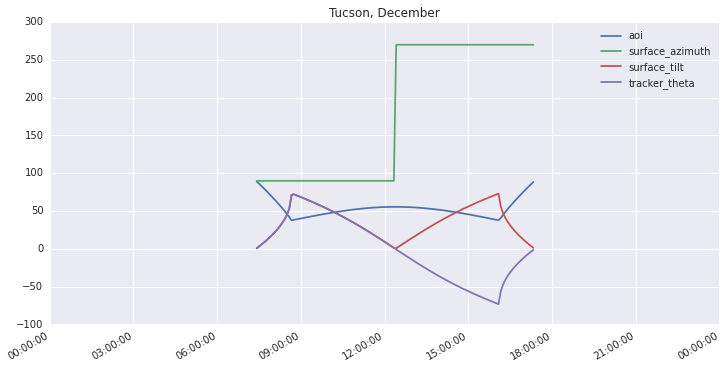

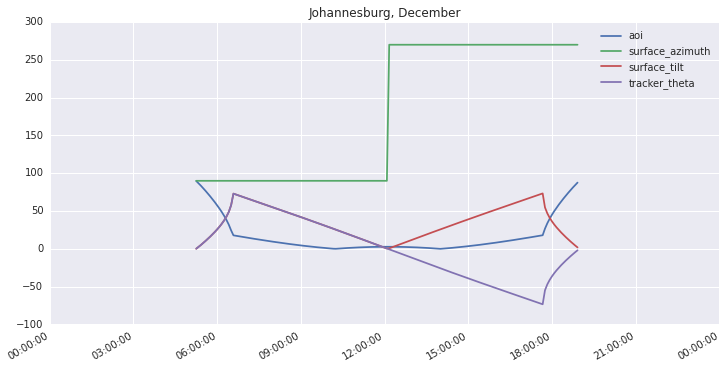

In [33]:
times = pd.date_range(start=datetime.datetime(2014,12,23), end=datetime.datetime(2014,12,24), freq='5Min')

pyephem_tus = pvlib.solarposition.pyephem(times, tus)
pyephem_joh = pvlib.solarposition.pyephem(times, johannesburg)

tracker_data = pvlib.tracking.singleaxis(pyephem_tus['apparent_zenith'], pyephem_tus['apparent_azimuth'],
                                         axis_tilt=0, axis_azimuth=0, max_angle=90,
                                         backtrack=True, gcr=2.0/7.0)
tracker_data.plot()
plt.title('Tucson, December')

tracker_data = pvlib.tracking.singleaxis(pyephem_joh['apparent_zenith'], pyephem_joh['apparent_azimuth'],
                                         axis_tilt=0, axis_azimuth=0, max_angle=90,
                                         backtrack=True, gcr=2.0/7.0)
tracker_data.plot()
plt.title('Johannesburg, December')

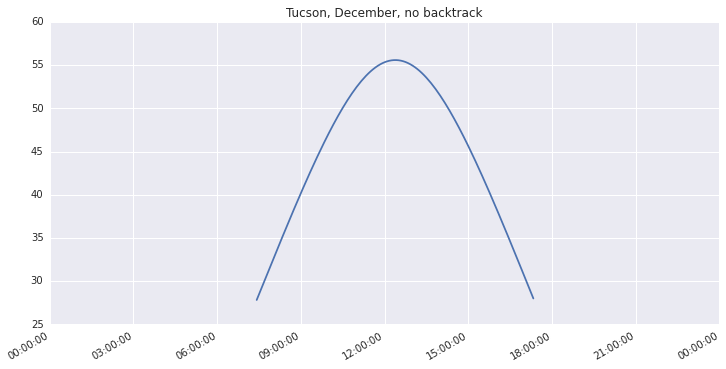

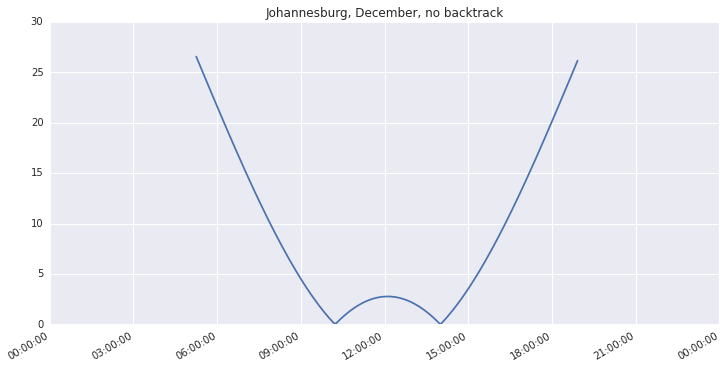

In [34]:
times = pd.date_range(start=datetime.datetime(2014,12,23), end=datetime.datetime(2014,12,24), freq='5Min')

pyephem_tus = pvlib.solarposition.pyephem(times, tus)
pyephem_joh = pvlib.solarposition.pyephem(times, johannesburg)

tracker_data = pvlib.tracking.singleaxis(pyephem_tus['apparent_zenith'], pyephem_tus['apparent_azimuth'],
                                         axis_tilt=0, axis_azimuth=0, max_angle=90,
                                         backtrack=False, gcr=2.0/7.0)
tracker_data['aoi'].plot()
plt.title('Tucson, December, no backtrack')

tracker_data = pvlib.tracking.singleaxis(pyephem_joh['apparent_zenith'], pyephem_joh['apparent_azimuth'],
                                         axis_tilt=0, axis_azimuth=0, max_angle=90,
                                         backtrack=False, gcr=2.0/7.0)
plt.figure()
tracker_data['aoi'].plot()
plt.title('Johannesburg, December, no backtrack')

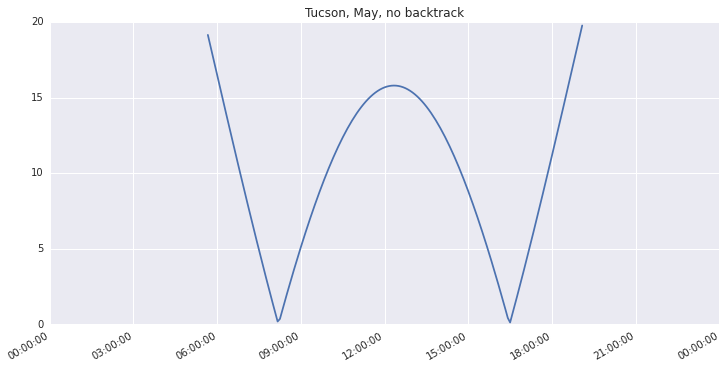

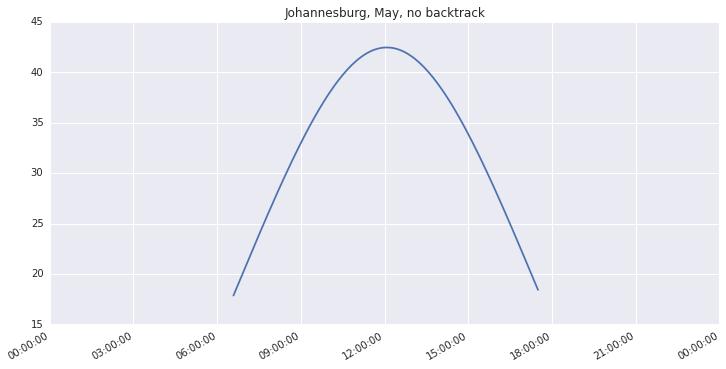

In [35]:
times = pd.date_range(start=datetime.datetime(2014,5,5), end=datetime.datetime(2014,5,6), freq='5Min')

pyephem_tus = pvlib.solarposition.pyephem(times, tus)
pyephem_joh = pvlib.solarposition.pyephem(times, johannesburg)

tracker_data = pvlib.tracking.singleaxis(pyephem_tus['apparent_zenith'], pyephem_tus['apparent_azimuth'],
                                         axis_tilt=0, axis_azimuth=0, max_angle=90,
                                         backtrack=False, gcr=2.0/7.0)
tracker_data['aoi'].plot()
plt.title('Tucson, May, no backtrack')

tracker_data = pvlib.tracking.singleaxis(pyephem_joh['apparent_zenith'], pyephem_joh['apparent_azimuth'],
                                         axis_tilt=0, axis_azimuth=0, max_angle=90,
                                         backtrack=False, gcr=2.0/7.0)
plt.figure()
tracker_data['aoi'].plot()
plt.title('Johannesburg, May, no backtrack')

### Calculate full POA irradiance

Finally, we'll put the tracker data together with the irradiance algorithms to determine plane-of-array irradiance.

(-100, 100)

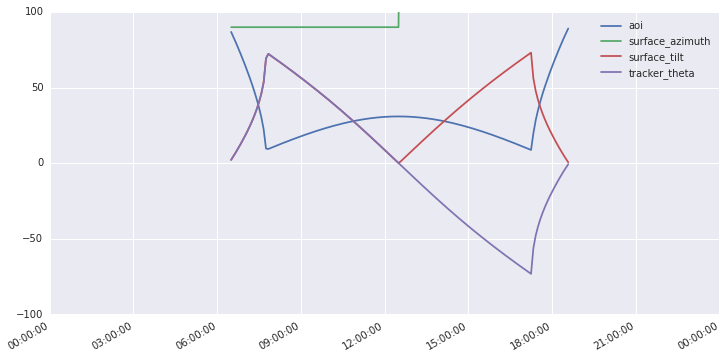

In [36]:
times = pd.date_range(start=datetime.datetime(2014,3,23), end=datetime.datetime(2014,3,24), freq='5Min')

pyephem_tus = pvlib.solarposition.pyephem(times, tus)
pyephem_joh = pvlib.solarposition.pyephem(times, johannesburg)

tracker_data = pvlib.tracking.singleaxis(pyephem_tus['apparent_zenith'], pyephem_tus['apparent_azimuth'],
                                         axis_tilt=0, axis_azimuth=0, max_angle=90,
                                         backtrack=True, gcr=2.0/7.0)
tracker_data.plot()
plt.ylim(-100,100)

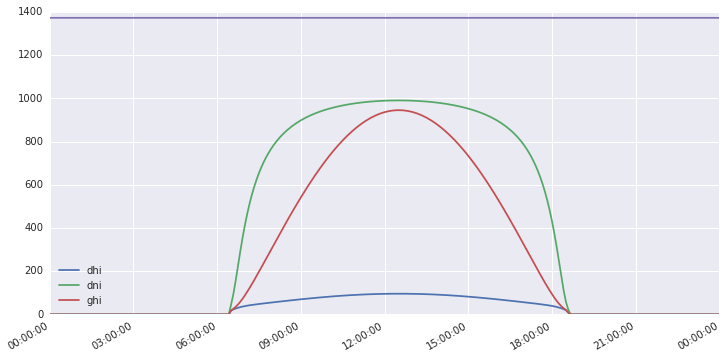

In [37]:
irrad_data = pvlib.clearsky.ineichen(times, tus, solarposition_method='pyephem')
dni_et = pd.Series(pvlib.irradiance.extraradiation(times.dayofyear, method='asce'), index=times).tz_localize(tus.tz)
irrad_data.plot()
dni_et.plot(label='DNI ET')

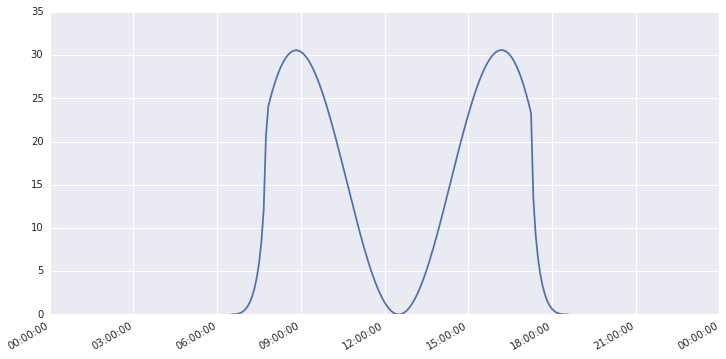

In [38]:
ground_irrad = pvlib.irradiance.grounddiffuse(tracker_data['surface_tilt'], irrad_data['ghi'], albedo=.25)
ground_irrad.plot()

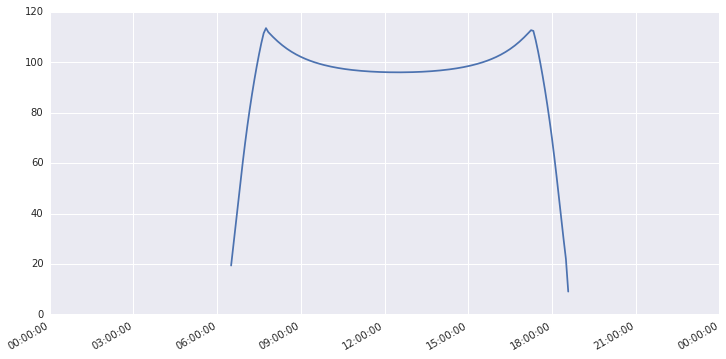

In [39]:
ephem_data = pyephem_tus

haydavies_diffuse = pvlib.irradiance.haydavies(tracker_data['surface_tilt'], tracker_data['surface_azimuth'], 
                                                irrad_data['dhi'], irrad_data['dni'], dni_et,
                                                ephem_data['apparent_zenith'], ephem_data['apparent_azimuth'])
haydavies_diffuse.plot(label='haydavies diffuse')

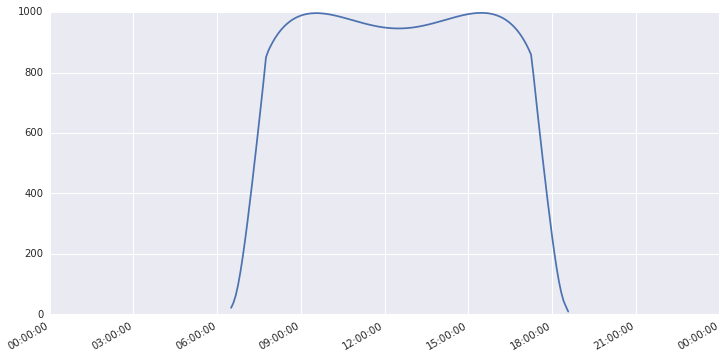

In [40]:
global_in_plane = cosd(tracker_data['aoi'])*irrad_data['dni'] + haydavies_diffuse + ground_irrad
global_in_plane.plot()

Do it again for another time of year.

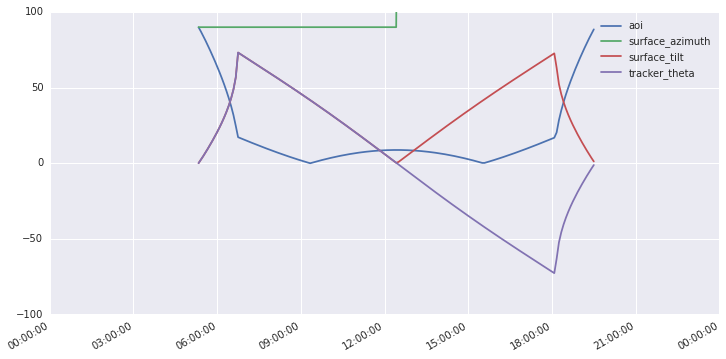

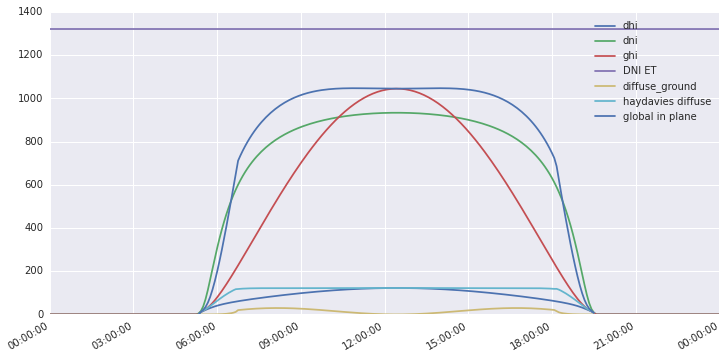

In [41]:
times = pd.date_range(start=datetime.datetime(2014,6,23), end=datetime.datetime(2014,6,24), freq='5Min')

pyephem_tus = pvlib.solarposition.pyephem(times, tus)
pyephem_joh = pvlib.solarposition.pyephem(times, johannesburg)

tracker_data = pvlib.tracking.singleaxis(pyephem_tus['apparent_zenith'], pyephem_tus['apparent_azimuth'],
                                         axis_tilt=0, axis_azimuth=0, max_angle=90,
                                         backtrack=True, gcr=2.0/7.0)
tracker_data.plot()
plt.ylim(-100,100)

irrad_data = pvlib.clearsky.ineichen(times, tus, solarposition_method='pyephem')
dni_et = pd.Series(pvlib.irradiance.extraradiation(times.dayofyear, method='asce'), index=times).tz_localize(tus.tz)
plt.figure()
irrad_data.plot()
dni_et.plot(label='DNI ET')

ground_irrad = pvlib.irradiance.grounddiffuse(tracker_data['surface_tilt'], irrad_data['ghi'], albedo=.25)
ground_irrad.plot()

ephem_data = pyephem_tus

haydavies_diffuse = pvlib.irradiance.haydavies(tracker_data['surface_tilt'], tracker_data['surface_azimuth'], 
                                                irrad_data['dhi'], irrad_data['dni'], dni_et,
                                                ephem_data['apparent_zenith'], ephem_data['apparent_azimuth'])
haydavies_diffuse.plot(label='haydavies diffuse')

global_in_plane = cosd(tracker_data['aoi'])*irrad_data['dni'] + haydavies_diffuse + ground_irrad
global_in_plane.plot(label='global in plane')

plt.legend()

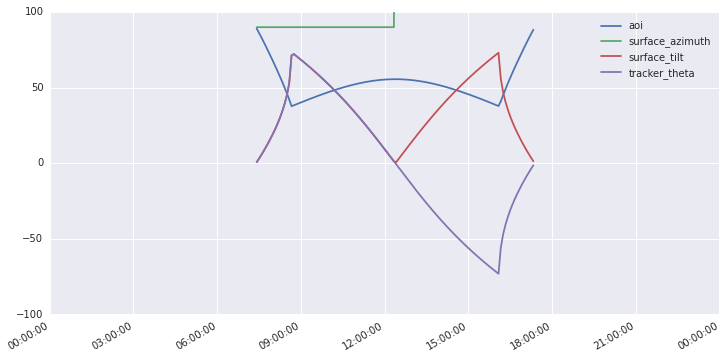

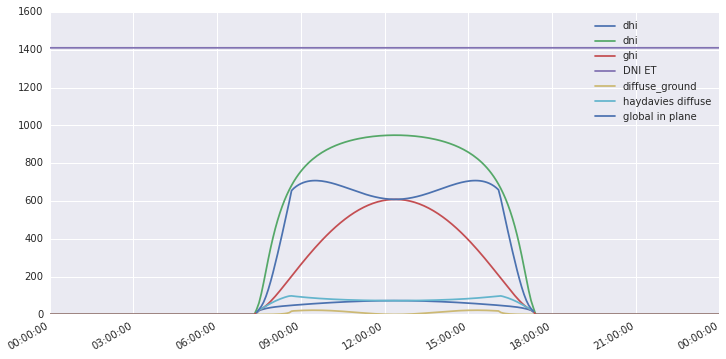

In [42]:
times = pd.date_range(start=datetime.datetime(2014,12,23), end=datetime.datetime(2014,12,24), freq='5Min')

pyephem_tus = pvlib.solarposition.pyephem(times, tus)
pyephem_joh = pvlib.solarposition.pyephem(times, johannesburg)

tracker_data = pvlib.tracking.singleaxis(pyephem_tus['apparent_zenith'], pyephem_tus['apparent_azimuth'],
                                         axis_tilt=0, axis_azimuth=0, max_angle=90,
                                         backtrack=True, gcr=2.0/7.0)
tracker_data.plot()
plt.ylim(-100,100)

irrad_data = pvlib.clearsky.ineichen(times, tus, solarposition_method='pyephem')
dni_et = pd.Series(pvlib.irradiance.extraradiation(times.dayofyear, method='asce'), index=times).tz_localize(tus.tz)
plt.figure()
irrad_data.plot()
dni_et.plot(label='DNI ET')

ground_irrad = pvlib.irradiance.grounddiffuse(tracker_data['surface_tilt'], irrad_data['ghi'], albedo=.25)
ground_irrad.plot()

ephem_data = pyephem_tus

haydavies_diffuse = pvlib.irradiance.haydavies(tracker_data['surface_tilt'], tracker_data['surface_azimuth'], 
                                                irrad_data['dhi'], irrad_data['dni'], dni_et,
                                                ephem_data['apparent_zenith'], ephem_data['apparent_azimuth'])
haydavies_diffuse.plot(label='haydavies diffuse')

global_in_plane = cosd(tracker_data['aoi'])*irrad_data['dni'] + haydavies_diffuse + ground_irrad
global_in_plane.plot(label='global in plane')

plt.legend()

### Reproduce examples from ``pvl_singleaxis.m``

In [43]:
abq = Location(35, -106, 'US/Mountain', 0, 'Albuquerque')
print(abq)

Albuquerque: latitude=35, longitude=-106, tz=US/Mountain, altitude=0


####Example 1:

Horizontal single axis tracking without back-tracking (max angle = 45 deg)

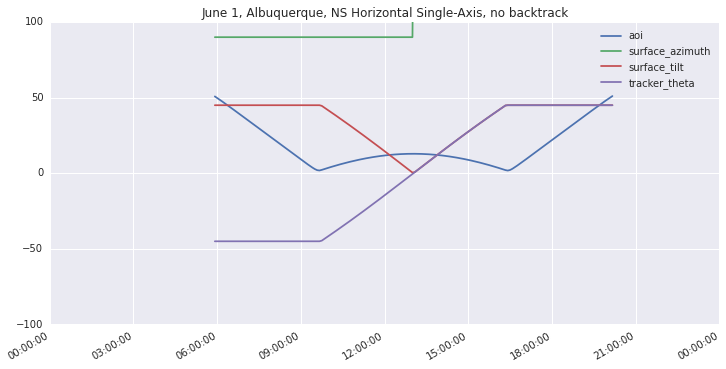

In [44]:
times = pd.date_range(start=datetime.datetime(2014,6,1), end=datetime.datetime(2014,6,2), freq='5Min')

pyephem_abq = pvlib.solarposition.pyephem(times, abq)

tracker_data = pvlib.tracking.singleaxis(pyephem_abq['apparent_zenith'], pyephem_abq['apparent_azimuth'],
                                         axis_tilt=0, axis_azimuth=180, max_angle=45,
                                         backtrack=False, gcr=2.0/7.0)
tracker_data.plot()
plt.ylim(-100,100)
plt.title('June 1, Albuquerque, NS Horizontal Single-Axis, no backtrack')

####Example 2:

Horizontal single axis tracking with back-tracking (assumes GCR of 0.3)

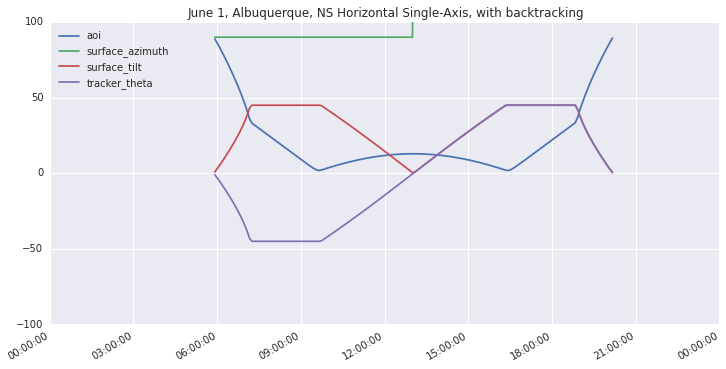

In [45]:
times = pd.date_range(start=datetime.datetime(2014,6,1), end=datetime.datetime(2014,6,2), freq='5Min')

pyephem_abq = pvlib.solarposition.pyephem(times, abq)

tracker_data = pvlib.tracking.singleaxis(pyephem_abq['apparent_zenith'], pyephem_abq['apparent_azimuth'],
                                         axis_tilt=0, axis_azimuth=180, max_angle=45,
                                         backtrack=True, gcr=.3)
tracker_data.plot()
plt.ylim(-100,100)
plt.title('June 1, Albuquerque, NS Horizontal Single-Axis, with backtracking')

####Example 3:

20 deg titled single axis tracking with back-tracking (assumes GCR of 0.3)

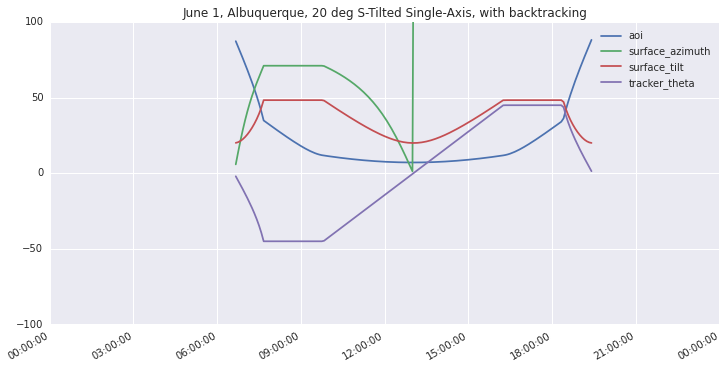

In [46]:
times = pd.date_range(start=datetime.datetime(2014,6,1), end=datetime.datetime(2014,6,2), freq='5Min')

pyephem_abq = pvlib.solarposition.pyephem(times, abq)

tracker_data = pvlib.tracking.singleaxis(pyephem_abq['apparent_zenith'], pyephem_abq['apparent_azimuth'],
                                         axis_tilt=20, axis_azimuth=180, max_angle=45,
                                         backtrack=True, gcr=.3)
tracker_data.plot()
plt.ylim(-100,100)
plt.title('June 1, Albuquerque, 20 deg S-Tilted Single-Axis, with backtracking')

### sketch of automated tests

In [47]:
import logging
logging.getLogger('pvlib').setLevel(logging.DEBUG)

test solar noon

In [48]:
apparent_zenith = pd.Series([10])
apparent_azimuth = pd.Series([180])
tracker_data = pvlib.tracking.singleaxis(apparent_zenith, apparent_azimuth,
                                         axis_tilt=0, axis_azimuth=0, max_angle=90,
                                         backtrack=True, gcr=2.0/7.0)
tracker_data

DEBUG:pvlib:tracking.singleaxis
DEBUG:pvlib:axis_tilt=0, axis_azimuth=0, max_angle=90, backtrack=True, gcr=0.286
DEBUG:pvlib:
apparent_zenith=
0    10
dtype: int64
apparent_azimuth=
0    180
dtype: int64
DEBUG:pvlib:axis_azimuth_south=-180
DEBUG:pvlib:applying backtracking
DEBUG:pvlib:rot_x=
[[ 1.  0.  0.]
 [ 0.  1. -0.]
 [ 0.  0.  1.]]
DEBUG:pvlib:panel_norm_earth=[[ 0.  0.  1.]]
DEBUG:pvlib:projected_normal=[[ 0.  0.  0.]]
DEBUG:pvlib:panel_norm_earth_mag=[ 1.], projected_normal_mag=[ 0.]
DEBUG:pvlib:renormalized projected_normal=[[ 0.  0.  0.]]


,aoi,surface_azimuth,surface_tilt,tracker_theta
0,10,90,0,0


In [49]:
apparent_zenith = pd.Series([60])
apparent_azimuth = pd.Series([90])
tracker_data = pvlib.tracking.singleaxis(apparent_zenith, apparent_azimuth,
                                         axis_tilt=0, axis_azimuth=180, max_angle=90,
                                         backtrack=True, gcr=2.0/7.0)
tracker_data

DEBUG:pvlib:tracking.singleaxis
DEBUG:pvlib:axis_tilt=0, axis_azimuth=180, max_angle=90, backtrack=True, gcr=0.286
DEBUG:pvlib:
apparent_zenith=
0    60
dtype: int64
apparent_azimuth=
0    90
dtype: int64
DEBUG:pvlib:axis_azimuth_south=0
DEBUG:pvlib:applying backtracking
DEBUG:pvlib:rot_x=
[[ 1.  0.  0.]
 [ 0.  1. -0.]
 [ 0.  0.  1.]]
DEBUG:pvlib:panel_norm_earth=[[-0.8660254 -0.         0.5      ]]
DEBUG:pvlib:projected_normal=[[-0.8660254 -0.         0.       ]]
DEBUG:pvlib:panel_norm_earth_mag=[ 1.], projected_normal_mag=[ 0.8660254]
DEBUG:pvlib:renormalized projected_normal=[[-1. -0.  0.]]


,aoi,surface_azimuth,surface_tilt,tracker_theta
0,0,90,60,-60


In [50]:
apparent_zenith = pd.Series([60])
apparent_azimuth = pd.Series([90])
tracker_data = pvlib.tracking.singleaxis(apparent_zenith, apparent_azimuth,
                                         axis_tilt=0, axis_azimuth=0, max_angle=90,
                                         backtrack=True, gcr=2.0/7.0)
tracker_data

DEBUG:pvlib:tracking.singleaxis
DEBUG:pvlib:axis_tilt=0, axis_azimuth=0, max_angle=90, backtrack=True, gcr=0.286
DEBUG:pvlib:
apparent_zenith=
0    60
dtype: int64
apparent_azimuth=
0    90
dtype: int64
DEBUG:pvlib:axis_azimuth_south=-180
DEBUG:pvlib:applying backtracking
DEBUG:pvlib:rot_x=
[[ 1.  0.  0.]
 [ 0.  1. -0.]
 [ 0.  0.  1.]]
DEBUG:pvlib:panel_norm_earth=[[ 0.8660254  0.         0.5      ]]
DEBUG:pvlib:projected_normal=[[ 0.8660254  0.         0.       ]]
DEBUG:pvlib:panel_norm_earth_mag=[ 1.], projected_normal_mag=[ 0.8660254]
DEBUG:pvlib:renormalized projected_normal=[[ 1.  0.  0.]]


,aoi,surface_azimuth,surface_tilt,tracker_theta
0,0,90,60,60


Test max

In [51]:
apparent_zenith = pd.Series([60])
apparent_azimuth = pd.Series([90])
tracker_data = pvlib.tracking.singleaxis(apparent_zenith, apparent_azimuth,
                                         axis_tilt=0, axis_azimuth=0, max_angle=45,
                                         backtrack=True, gcr=2.0/7.0)
tracker_data

DEBUG:pvlib:tracking.singleaxis
DEBUG:pvlib:axis_tilt=0, axis_azimuth=0, max_angle=45, backtrack=True, gcr=0.286
DEBUG:pvlib:
apparent_zenith=
0    60
dtype: int64
apparent_azimuth=
0    90
dtype: int64
DEBUG:pvlib:axis_azimuth_south=-180
DEBUG:pvlib:applying backtracking
DEBUG:pvlib:rot_x=
[[ 1.  0.  0.]
 [ 0.  1. -0.]
 [ 0.  0.  1.]]
DEBUG:pvlib:panel_norm_earth=[[ 0.70710678  0.          0.70710678]]
DEBUG:pvlib:projected_normal=[[ 0.70710678  0.          0.        ]]
DEBUG:pvlib:panel_norm_earth_mag=[ 1.], projected_normal_mag=[ 0.70710678]
DEBUG:pvlib:renormalized projected_normal=[[ 1.  0.  0.]]


,aoi,surface_azimuth,surface_tilt,tracker_theta
0,15,90,45,45


Test backtrack bool

In [52]:
apparent_zenith = pd.Series([80])
apparent_azimuth = pd.Series([90])
tracker_data = pvlib.tracking.singleaxis(apparent_zenith, apparent_azimuth,
                                         axis_tilt=0, axis_azimuth=0, max_angle=90,
                                         backtrack=False, gcr=2.0/7.0)
tracker_data

DEBUG:pvlib:tracking.singleaxis
DEBUG:pvlib:axis_tilt=0, axis_azimuth=0, max_angle=90, backtrack=False, gcr=0.286
DEBUG:pvlib:
apparent_zenith=
0    80
dtype: int64
apparent_azimuth=
0    90
dtype: int64
DEBUG:pvlib:axis_azimuth_south=-180
DEBUG:pvlib:no backtracking
DEBUG:pvlib:rot_x=
[[ 1.  0.  0.]
 [ 0.  1. -0.]
 [ 0.  0.  1.]]
DEBUG:pvlib:panel_norm_earth=[[ 0.98480775  0.          0.17364818]]
DEBUG:pvlib:projected_normal=[[ 0.98480775  0.          0.        ]]
DEBUG:pvlib:panel_norm_earth_mag=[ 1.], projected_normal_mag=[ 0.98480775]
DEBUG:pvlib:renormalized projected_normal=[[ 1.  0.  0.]]


,aoi,surface_azimuth,surface_tilt,tracker_theta
0,8.537736e-07,90,80,80


In [53]:
apparent_zenith = pd.Series([80])
apparent_azimuth = pd.Series([90])
tracker_data = pvlib.tracking.singleaxis(apparent_zenith, apparent_azimuth,
                                         axis_tilt=0, axis_azimuth=0, max_angle=90,
                                         backtrack=True, gcr=2.0/7.0)
tracker_data

DEBUG:pvlib:tracking.singleaxis
DEBUG:pvlib:axis_tilt=0, axis_azimuth=0, max_angle=90, backtrack=True, gcr=0.286
DEBUG:pvlib:
apparent_zenith=
0    80
dtype: int64
apparent_azimuth=
0    90
dtype: int64
DEBUG:pvlib:axis_azimuth_south=-180
DEBUG:pvlib:applying backtracking
DEBUG:pvlib:rot_x=
[[ 1.  0.  0.]
 [ 0.  1. -0.]
 [ 0.  0.  1.]]
DEBUG:pvlib:panel_norm_earth=[[ 0.46063877  0.          0.8875877 ]]
DEBUG:pvlib:projected_normal=[[ 0.46063877  0.          0.        ]]
DEBUG:pvlib:panel_norm_earth_mag=[ 1.], projected_normal_mag=[ 0.46063877]
DEBUG:pvlib:renormalized projected_normal=[[ 1.  0.  0.]]


,aoi,surface_azimuth,surface_tilt,tracker_theta
0,52.571666,90,27.428334,27.428334


Test axis_tilt

In [54]:
apparent_zenith = pd.Series([30])
apparent_azimuth = pd.Series([135])
tracker_data = pvlib.tracking.singleaxis(apparent_zenith, apparent_azimuth,
                                         axis_tilt=30, axis_azimuth=180, max_angle=90,
                                         backtrack=True, gcr=2.0/7.0)
tracker_data

DEBUG:pvlib:tracking.singleaxis
DEBUG:pvlib:axis_tilt=30, axis_azimuth=180, max_angle=90, backtrack=True, gcr=0.286
DEBUG:pvlib:
apparent_zenith=
0    30
dtype: int64
apparent_azimuth=
0    135
dtype: int64
DEBUG:pvlib:axis_azimuth_south=0
DEBUG:pvlib:applying backtracking
DEBUG:pvlib:rot_x=
[[ 1.         0.         0.       ]
 [ 0.         0.8660254  0.5      ]
 [ 0.        -0.5        0.8660254]]
DEBUG:pvlib:panel_norm_earth=[[-0.35643161  0.46716071  0.80914608]]
DEBUG:pvlib:projected_normal=[[-0.35643161  0.46716071  0.        ]]
DEBUG:pvlib:panel_norm_earth_mag=[ 1.], projected_normal_mag=[ 0.58760754]
DEBUG:pvlib:renormalized projected_normal=[[-0.60658106  0.79502164  0.        ]]


,aoi,surface_azimuth,surface_tilt,tracker_theta
0,7.286245,37.3427,35.987415,-20.88121


In [55]:
apparent_zenith = pd.Series([30])
apparent_azimuth = pd.Series([135])
tracker_data = pvlib.tracking.singleaxis(apparent_zenith, apparent_azimuth,
                                         axis_tilt=30, axis_azimuth=0, max_angle=90,
                                         backtrack=True, gcr=2.0/7.0)
tracker_data

DEBUG:pvlib:tracking.singleaxis
DEBUG:pvlib:axis_tilt=30, axis_azimuth=0, max_angle=90, backtrack=True, gcr=0.286
DEBUG:pvlib:
apparent_zenith=
0    30
dtype: int64
apparent_azimuth=
0    135
dtype: int64
DEBUG:pvlib:axis_azimuth_south=-180
DEBUG:pvlib:applying backtracking
DEBUG:pvlib:rot_x=
[[ 1.         0.         0.       ]
 [ 0.         0.8660254  0.5      ]
 [ 0.        -0.5        0.8660254]]
DEBUG:pvlib:panel_norm_earth=[[ 0.52495936  0.42556365  0.73709786]]
DEBUG:pvlib:projected_normal=[[ 0.52495936  0.42556365  0.        ]]
DEBUG:pvlib:panel_norm_earth_mag=[ 1.], projected_normal_mag=[ 0.67578602]
DEBUG:pvlib:renormalized projected_normal=[[ 0.77681299  0.62973135  0.        ]]


,aoi,surface_azimuth,surface_tilt,tracker_theta
0,47.66322,129.030305,42.515219,31.665508


Test axis_azimuth

In [56]:
apparent_zenith = pd.Series([30])
apparent_azimuth = pd.Series([90])
tracker_data = pvlib.tracking.singleaxis(apparent_zenith, apparent_azimuth,
                                         axis_tilt=0, axis_azimuth=90, max_angle=90,
                                         backtrack=True, gcr=2.0/7.0)
tracker_data

DEBUG:pvlib:tracking.singleaxis
DEBUG:pvlib:axis_tilt=0, axis_azimuth=90, max_angle=90, backtrack=True, gcr=0.286
DEBUG:pvlib:
apparent_zenith=
0    30
dtype: int64
apparent_azimuth=
0    90
dtype: int64
DEBUG:pvlib:axis_azimuth_south=-90
DEBUG:pvlib:applying backtracking
DEBUG:pvlib:rot_x=
[[ 1.  0.  0.]
 [ 0.  1. -0.]
 [ 0.  0.  1.]]
DEBUG:pvlib:panel_norm_earth=[[ 0.  0.  1.]]
DEBUG:pvlib:projected_normal=[[ 0.  0.  0.]]
DEBUG:pvlib:panel_norm_earth_mag=[ 1.], projected_normal_mag=[ 0.]
DEBUG:pvlib:renormalized projected_normal=[[ 0.  0.  0.]]


,aoi,surface_azimuth,surface_tilt,tracker_theta
0,30,180,0,0


In [57]:
apparent_zenith = pd.Series([30])
apparent_azimuth = pd.Series([180])
tracker_data = pvlib.tracking.singleaxis(apparent_zenith, apparent_azimuth,
                                         axis_tilt=0, axis_azimuth=90, max_angle=90,
                                         backtrack=True, gcr=2.0/7.0)
tracker_data

DEBUG:pvlib:tracking.singleaxis
DEBUG:pvlib:axis_tilt=0, axis_azimuth=90, max_angle=90, backtrack=True, gcr=0.286
DEBUG:pvlib:
apparent_zenith=
0    30
dtype: int64
apparent_azimuth=
0    180
dtype: int64
DEBUG:pvlib:axis_azimuth_south=-90
DEBUG:pvlib:applying backtracking
DEBUG:pvlib:rot_x=
[[ 1.  0.  0.]
 [ 0.  1. -0.]
 [ 0.  0.  1.]]
DEBUG:pvlib:panel_norm_earth=[[ 0.5        0.         0.8660254]]
DEBUG:pvlib:projected_normal=[[ 0.5  0.   0. ]]
DEBUG:pvlib:panel_norm_earth_mag=[ 1.], projected_normal_mag=[ 0.5]
DEBUG:pvlib:renormalized projected_normal=[[ 1.  0.  0.]]


,aoi,surface_azimuth,surface_tilt,tracker_theta
0,0,180,30,30


In [58]:
apparent_zenith = pd.Series([30])
apparent_azimuth = pd.Series([180])
tracker_data = pvlib.tracking.singleaxis(apparent_zenith, apparent_azimuth,
                                         axis_tilt=0, axis_azimuth=90, max_angle=90,
                                         backtrack=True, gcr=2.0/7.0)
tracker_data

DEBUG:pvlib:tracking.singleaxis
DEBUG:pvlib:axis_tilt=0, axis_azimuth=90, max_angle=90, backtrack=True, gcr=0.286
DEBUG:pvlib:
apparent_zenith=
0    30
dtype: int64
apparent_azimuth=
0    180
dtype: int64
DEBUG:pvlib:axis_azimuth_south=-90
DEBUG:pvlib:applying backtracking
DEBUG:pvlib:rot_x=
[[ 1.  0.  0.]
 [ 0.  1. -0.]
 [ 0.  0.  1.]]
DEBUG:pvlib:panel_norm_earth=[[ 0.5        0.         0.8660254]]
DEBUG:pvlib:projected_normal=[[ 0.5  0.   0. ]]
DEBUG:pvlib:panel_norm_earth_mag=[ 1.], projected_normal_mag=[ 0.5]
DEBUG:pvlib:renormalized projected_normal=[[ 1.  0.  0.]]


,aoi,surface_azimuth,surface_tilt,tracker_theta
0,0,180,30,30


In [59]:
apparent_zenith = pd.Series([30])
apparent_azimuth = pd.Series([150])
tracker_data = pvlib.tracking.singleaxis(apparent_zenith, apparent_azimuth,
                                         axis_tilt=0, axis_azimuth=170, max_angle=90,
                                         backtrack=True, gcr=2.0/7.0)
tracker_data

DEBUG:pvlib:tracking.singleaxis
DEBUG:pvlib:axis_tilt=0, axis_azimuth=170, max_angle=90, backtrack=True, gcr=0.286
DEBUG:pvlib:
apparent_zenith=
0    30
dtype: int64
apparent_azimuth=
0    150
dtype: int64
DEBUG:pvlib:axis_azimuth_south=-10
DEBUG:pvlib:applying backtracking
DEBUG:pvlib:rot_x=
[[ 1.  0.  0.]
 [ 0.  1. -0.]
 [ 0.  0.  1.]]
DEBUG:pvlib:panel_norm_earth=[[-0.19372463 -0.          0.98105595]]
DEBUG:pvlib:projected_normal=[[-0.19372463 -0.          0.        ]]
DEBUG:pvlib:panel_norm_earth_mag=[ 1.], projected_normal_mag=[ 0.19372463]
DEBUG:pvlib:renormalized projected_normal=[[-1. -0.  0.]]


,aoi,surface_azimuth,surface_tilt,tracker_theta
0,28.024321,80,11.170229,-11.170229


In [60]:
apparent_zenith = pd.Series([30])
apparent_azimuth = pd.Series([180])
tracker_data = pvlib.tracking.singleaxis(apparent_zenith, apparent_azimuth,
                                         axis_tilt=0, axis_azimuth=170, max_angle=90,
                                         backtrack=True, gcr=2.0/7.0)
tracker_data

DEBUG:pvlib:tracking.singleaxis
DEBUG:pvlib:axis_tilt=0, axis_azimuth=170, max_angle=90, backtrack=True, gcr=0.286
DEBUG:pvlib:
apparent_zenith=
0    30
dtype: int64
apparent_azimuth=
0    180
dtype: int64
DEBUG:pvlib:axis_azimuth_south=-10
DEBUG:pvlib:applying backtracking
DEBUG:pvlib:rot_x=
[[ 1.  0.  0.]
 [ 0.  1. -0.]
 [ 0.  0.  1.]]
DEBUG:pvlib:panel_norm_earth=[[ 0.09975574  0.          0.99501196]]
DEBUG:pvlib:projected_normal=[[ 0.09975574  0.          0.        ]]
DEBUG:pvlib:panel_norm_earth_mag=[ 1.], projected_normal_mag=[ 0.09975574]
DEBUG:pvlib:renormalized projected_normal=[[ 1.  0.  0.]]


,aoi,surface_azimuth,surface_tilt,tracker_theta
0,29.498704,260,5.725105,5.725105


In [61]:
apparent_zenith = pd.Series([10])
apparent_azimuth = pd.Series([180])
tracker_data = pvlib.tracking.singleaxis(apparent_zenith, apparent_azimuth,
                                         axis_tilt=0, axis_azimuth=0, max_angle=90,
                                         backtrack=True, gcr=2.0/7.0)
tracker_data

DEBUG:pvlib:tracking.singleaxis
DEBUG:pvlib:axis_tilt=0, axis_azimuth=0, max_angle=90, backtrack=True, gcr=0.286
DEBUG:pvlib:
apparent_zenith=
0    10
dtype: int64
apparent_azimuth=
0    180
dtype: int64
DEBUG:pvlib:axis_azimuth_south=-180
DEBUG:pvlib:applying backtracking
DEBUG:pvlib:rot_x=
[[ 1.  0.  0.]
 [ 0.  1. -0.]
 [ 0.  0.  1.]]
DEBUG:pvlib:panel_norm_earth=[[ 0.  0.  1.]]
DEBUG:pvlib:projected_normal=[[ 0.  0.  0.]]
DEBUG:pvlib:panel_norm_earth_mag=[ 1.], projected_normal_mag=[ 0.]
DEBUG:pvlib:renormalized projected_normal=[[ 0.  0.  0.]]


,aoi,surface_azimuth,surface_tilt,tracker_theta
0,10,90,0,0


This is supposed to fail...

In [62]:
apparent_zenith = pd.Series([10])
apparent_azimuth = pd.Series([180,90])
tracker_data = pvlib.tracking.singleaxis(apparent_zenith, apparent_azimuth,
                                         axis_tilt=0, axis_azimuth=0, max_angle=90,
                                         backtrack=True, gcr=2.0/7.0)
tracker_data

DEBUG:pvlib:tracking.singleaxis
DEBUG:pvlib:axis_tilt=0, axis_azimuth=0, max_angle=90, backtrack=True, gcr=0.286
DEBUG:pvlib:
apparent_zenith=
0    10
dtype: int64
apparent_azimuth=
0    180
1     90
dtype: int64


ValueError: apparent_azimuth.index and apparent_zenith.index must match.

In [ ]:
logging.getLogger('pvlib').setLevel(logging.WARNING)